<a href="https://colab.research.google.com/github/ethan-yoo/2022_aiffel_exp/blob/main/E08_ImNotSnapChat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E08. 스티커 필터 만들어보기**

- 인스타그램, 스냅챗 등에서 흔히 쓰는 고양이 수염 필터를 만들어봅시다.

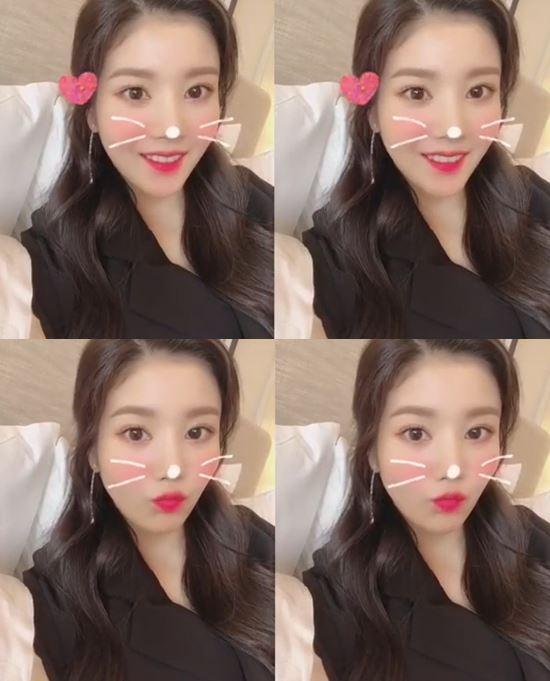

이런 것 말이죠!

---

## **INDEX**

**1. 데이터 가져오기**

**2. 얼굴 검출하기**

**3. 랜드마크 처리하기**

**4. 스티커 적용하기**

**5. 다양하게 시도해보기**

**6. 회고**

---

## **01. 데이터 가져오기**

- 필터를 씌울 사진을 먼저 가져옵니다.

In [ ]:
from google.colab import drive

drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [158]:
# 라이브러리 가져오기
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

print('Done!')

Done!


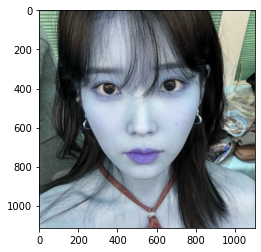

In [159]:
# 이미지 읽기

my_image_path = '/content/mydrive/MyDrive/AIFFEL/E08/original_image/아이유1.png'
img_bgr = cv2.imread(my_image_path, cv2.IMREAD_UNCHANGED)    # OpenCV로 이미지를 불러오기, RGBA 옵션으로 shape 맞춤
plt.imshow(img_bgr)
plt.show()

📷 사용할 필터 이미지가 알파채널을 가진 PNG이기 때문에 shape를 맞추기 위해 RGBA 옵션을 줘서 읽어왔습니다.

BGR 순으로 읽어왔으니 RGB 이미지로 바꿔줍니다.


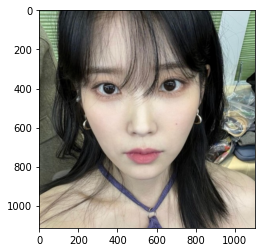

In [160]:
# 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## **02. 얼굴 검출하기**

- 얼굴이 어디 있는지 인식해봅시다.

In [161]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()

print("Done!")

Done!


In [162]:
# 업샘플링
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

print("Done!")

Done!


rectangles[[(206, 206) (872, 872)]]


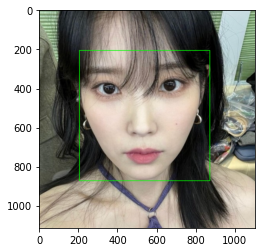

In [163]:
# 찾은 얼굴 영역 박스 리스트

print(dlib_rects)   

# 그때그때 필요한 이미지를 복사해 사용
img_show = img_bgr.copy()

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

📷 귀신같이 잘 찾아냈네요!

## **03. 랜드마크 처리하기**
- dlib의 pre-trained 모델을 사용합니다.

In [ ]:
model_path = '/content/mydrive/MyDrive/AIFFEL/E08/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

print('Done!')

Done!


In [ ]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 탐색
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)

    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


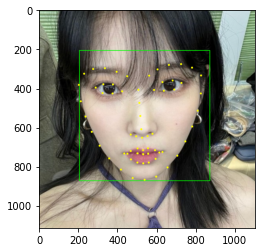

In [ ]:
# 랜드마크 출력

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

📷 잘 보이도록 인자를 약간 조정했습니다. 잘 잡아주고 있네요.

추후 사용할 이미지도 미리 복사해 놓습니다.

In [ ]:
# 추후 사용할 이미지 복사용
img_show2 = img_show.copy()

## **04. 스티커 적용해보기**

- 스티커를 어디에 붙이면 좋을지 생각해봅시다. 먼저 스티커 모양을 봐야겠죠.

- 알파 채널을 가진 PNG 이미지이니 RGBA로 읽어옵니다.

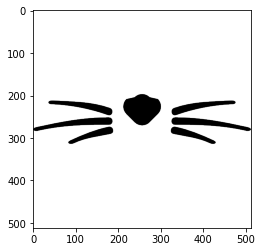

In [ ]:
sticker_path = '/content/mydrive/MyDrive/AIFFEL/E08/filter_image/cat-whiskers.png'

# 스티커 출력
img_sticker = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
plt.imshow(img_sticker)

📷 음... 고양이 수염의 가운데 부분이 코 끝에 오면 될 것 같습니다.

(x = 코 끝, y = 코 끝) 으로 한번 진행해보겠습니다.

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):

    # 코끝 인덱스 = 33
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1] + dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(526, 652)
(x,y) : (526,985)
(w,h) : (667,667)


📷 아이유의 코끝 위치는 (526, 652) 로군요. 스티커를 가져와서 붙여봅시다.

In [ ]:
# 리사이즈
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(667, 667, 4)


In [ ]:
# 좌표 조정
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (193,318)


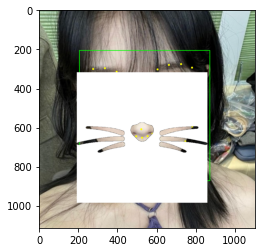

In [ ]:
# img_show[from:to] 형식
sticker_area = img_show[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

📷 어? 배경이 나오고 필터 이미지가 사라졌습니다.

왜 그런지 스티커 데이터를 살펴보겠습니다.

In [ ]:
print(img_sticker)

[[[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 ...

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]]


📷 흠, `np.where`에서 0을 주니 검은색을 다 지워버리는군요.

흰색 코드인 255를 설정해주면 될 것 같습니다.

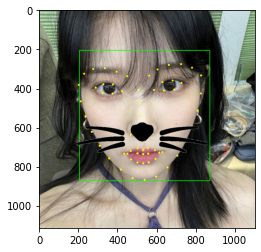

In [ ]:
# 앞서 만들어둔 복사본을 사용합니다.
sticker_area = img_show2[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show2[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

📷 좋습니다. 오리지널 이미지를 하나 복사해서 그 위에 출력해보겠습니다.

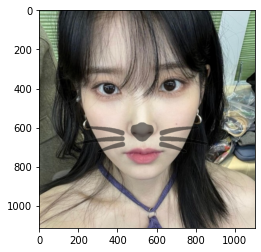

In [ ]:
img_show3 = img_bgr.copy()

sticker_area = img_show3[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# add weight 조정하여 투명도 조절
add = cv2.addWeighted(sticker_area, 0.5, img_sticker, 0.3, 0)

img_show3[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,add).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

📷 잘 처리되었습니다!

---

## **05. 다양하게 시도해보기**

### **05-1. 각도 바꾸기**

- 각도가 바뀌어도 잘 인식할까요?

- 편의상 전체 과정을 함수화하여 사용합니다.

- 함수화 코드는 홍성현님([링크](https://github.com/seonghyun97/Aiffel_Exploration/blob/master/%5BE-08%5DCameraSticker.ipynb)) 코드를 사용했습니다.

(성현님 감사해요! 😉)

In [177]:
def sticker_app(img_path, sticker_path, model_path, background = 255):
    my_image_path = img_path
    img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
    img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
    
    plt.figure(figsize=(15, 5)) 
    plt.subplot(131)
    plt.title('Before')
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

    # detector를 선언합니다
    detector_hog = dlib.get_frontal_face_detector()

    # detector_hog를 이용해서 얼굴의 bounding box를 추출
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    #  landmark 모델을 불러옵니다.
    model_path = model_path
    landmark_predictor = dlib.shape_predictor(model_path)
    
        
    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다. 찾은 face landmark마다 sticker를 붙혀줍니다.
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    # landmark 받았는지 확인
    try:
        if len(list_landmarks) <1:
            # 에러발생
            raise Exception("No No it's not face") 
    # 에러 발생 시 print문
    except Exception as e:
        print(e)
        
    # 에러 발생 안나면 진행
    else:
        for landmark in list_landmarks:
            for point in landmark:
                cv2.circle(img_show, point, 2, (0, 255, 255), -1)

        plt.subplot(132)
        plt.title('Computing')
        plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

        for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
            x = landmark[33][0]
            y = landmark[33][1]
            w = h = dlib_rect.width()

            # sticker_path = sticker_path
            img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
            img_sticker = cv2.resize(img_sticker, (w,h))
            refined_x = x - w // 2
            refined_y = y - h // 2

            if refined_x < 0: 
                img_sticker = img_sticker[:, -refined_x:]
                refined_x = 0
            if refined_y < 0:
                img_sticker = img_sticker[-refined_y:, :]
                refined_y = 0

            # 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
            sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
            img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
                np.where(img_sticker== background,sticker_area,img_sticker).astype(np.uint8)

        
        plt.subplot(133)
        plt.title('After')
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()

No No it's not face


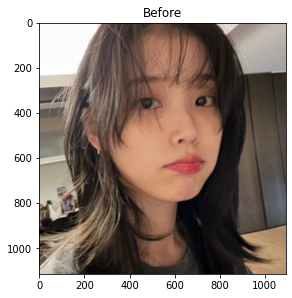

In [179]:
img_path = '/content/mydrive/MyDrive/AIFFEL/E08/original_image/아이유2.png'
sticker_path = '/content/mydrive/MyDrive/AIFFEL/E08/filter_image/cat-whiskers.png'
model_path = '/content/mydrive/MyDrive/AIFFEL/E08/model/shape_predictor_68_face_landmarks.dat'

sticker_app(img_path, sticker_path, model_path)

📷 헉, 그렇게 많이 틀어진 것 같지 않은데도 인식을 못하는군요.

---


### **05-2. 인종과 성별 바꿔보기**

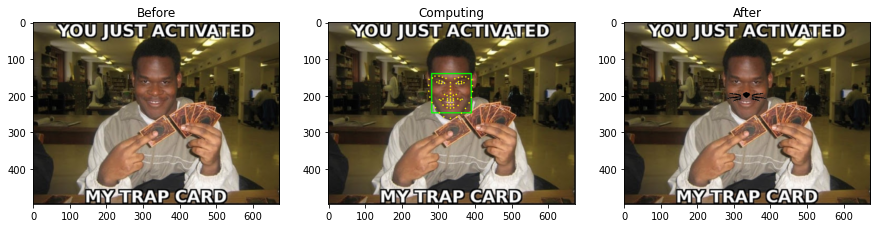

In [180]:
img_path = '/content/mydrive/MyDrive/AIFFEL/E08/original_image/함정카드.png'

sticker_app(img_path, sticker_path, model_path)

📷 정면은 인종이나 성별이 바뀌어도 잘 인식합니다.

---

### **05-3. 캐릭터도 인식 가능할까?**

No No it's not face


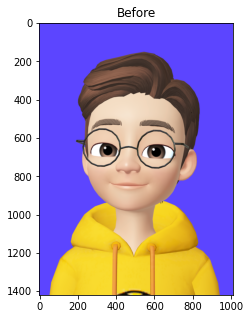

In [181]:
img_path = '/content/mydrive/MyDrive/AIFFEL/E08/original_image/제페토2.png'

sticker_app(img_path, sticker_path, model_path)

📷 정면이더라도 캐릭터는 인식을 못하네요.

---

# **회고**

- 생각보다 인식률이 저조합니다. 특히 머리카락 등으로 가려지거나, 캐릭터처럼 데포르메된 인물은 인물로 인식을 못하는데, 더 성능이 좋은 모델을 사용하면 개선이 가능할 것 같습니다.

- 스티커 이미지를 RGB로 읽어오든 RGBA로 읽어오든, 결국 `np.where` 메소드를 쓰는 것은 똑같으니 굳이 알파값을 읽을 필요는 없을 것 같습니다. 연산량만 늘어나네요.

- 고난이도로 갈 수록 기본적인 파이썬 코딩 실력이 중요해지고 있는 느낌이 듭니다. 백준이라도 풀면서 자체적으로 공부를 따로 해야 할 것 같습니다.

### **끝!**